In [1]:
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("DoubletFinder")
})

devtools::source_url("https://raw.githubusercontent.com/chansigit/scSnippet/master/doublet.removal.R")

SHA-1 hash of file is a9669b5ae399aa1fad9f03a5021a0c8d914d4a4e



In [2]:
path<-"/stor/chensijie/ILC_quants/20200210/soup_adjusted/FLaLP_soup"
proj.name <-"FLaLP"

In [3]:
tic()
CreateSeuratObject(counts= Read10X(data.dir= path), project = proj.name, min.cells = 0, min.features = 0) %>%
#RenameCells(add.cell.id = proj.name) %>%
PercentageFeatureSet(pattern = "^mt-", col.name = "percent.mt") -> seu
toc()


options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5),verbose=FALSE)
toc()

7.466 sec elapsed


Centering and scaling data matrix



11.131 sec elapsed
25.399 sec elapsed
3.237 sec elapsed


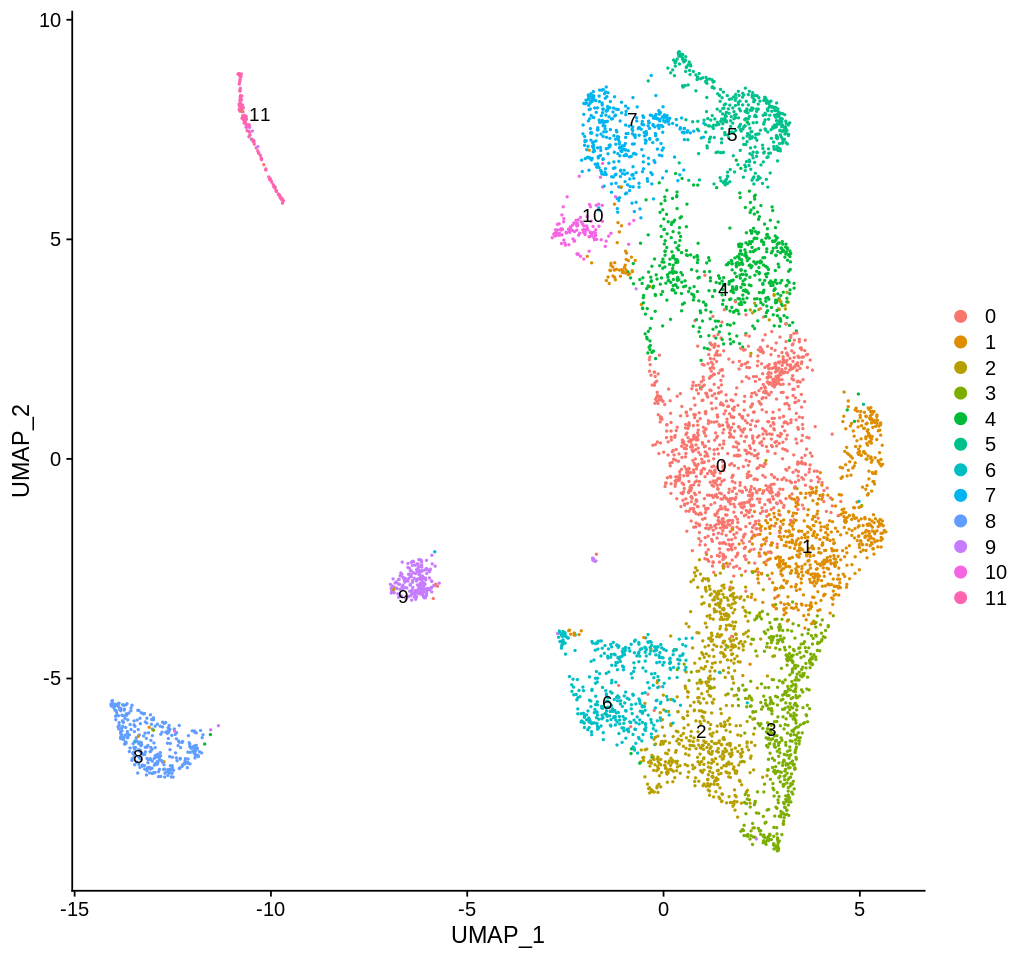

In [4]:
options(repr.plot.width=8.5, repr.plot.height=8)
UMAPPlot(seu, group.by="RNA_snn_res.0.5", label=T,repel=T)

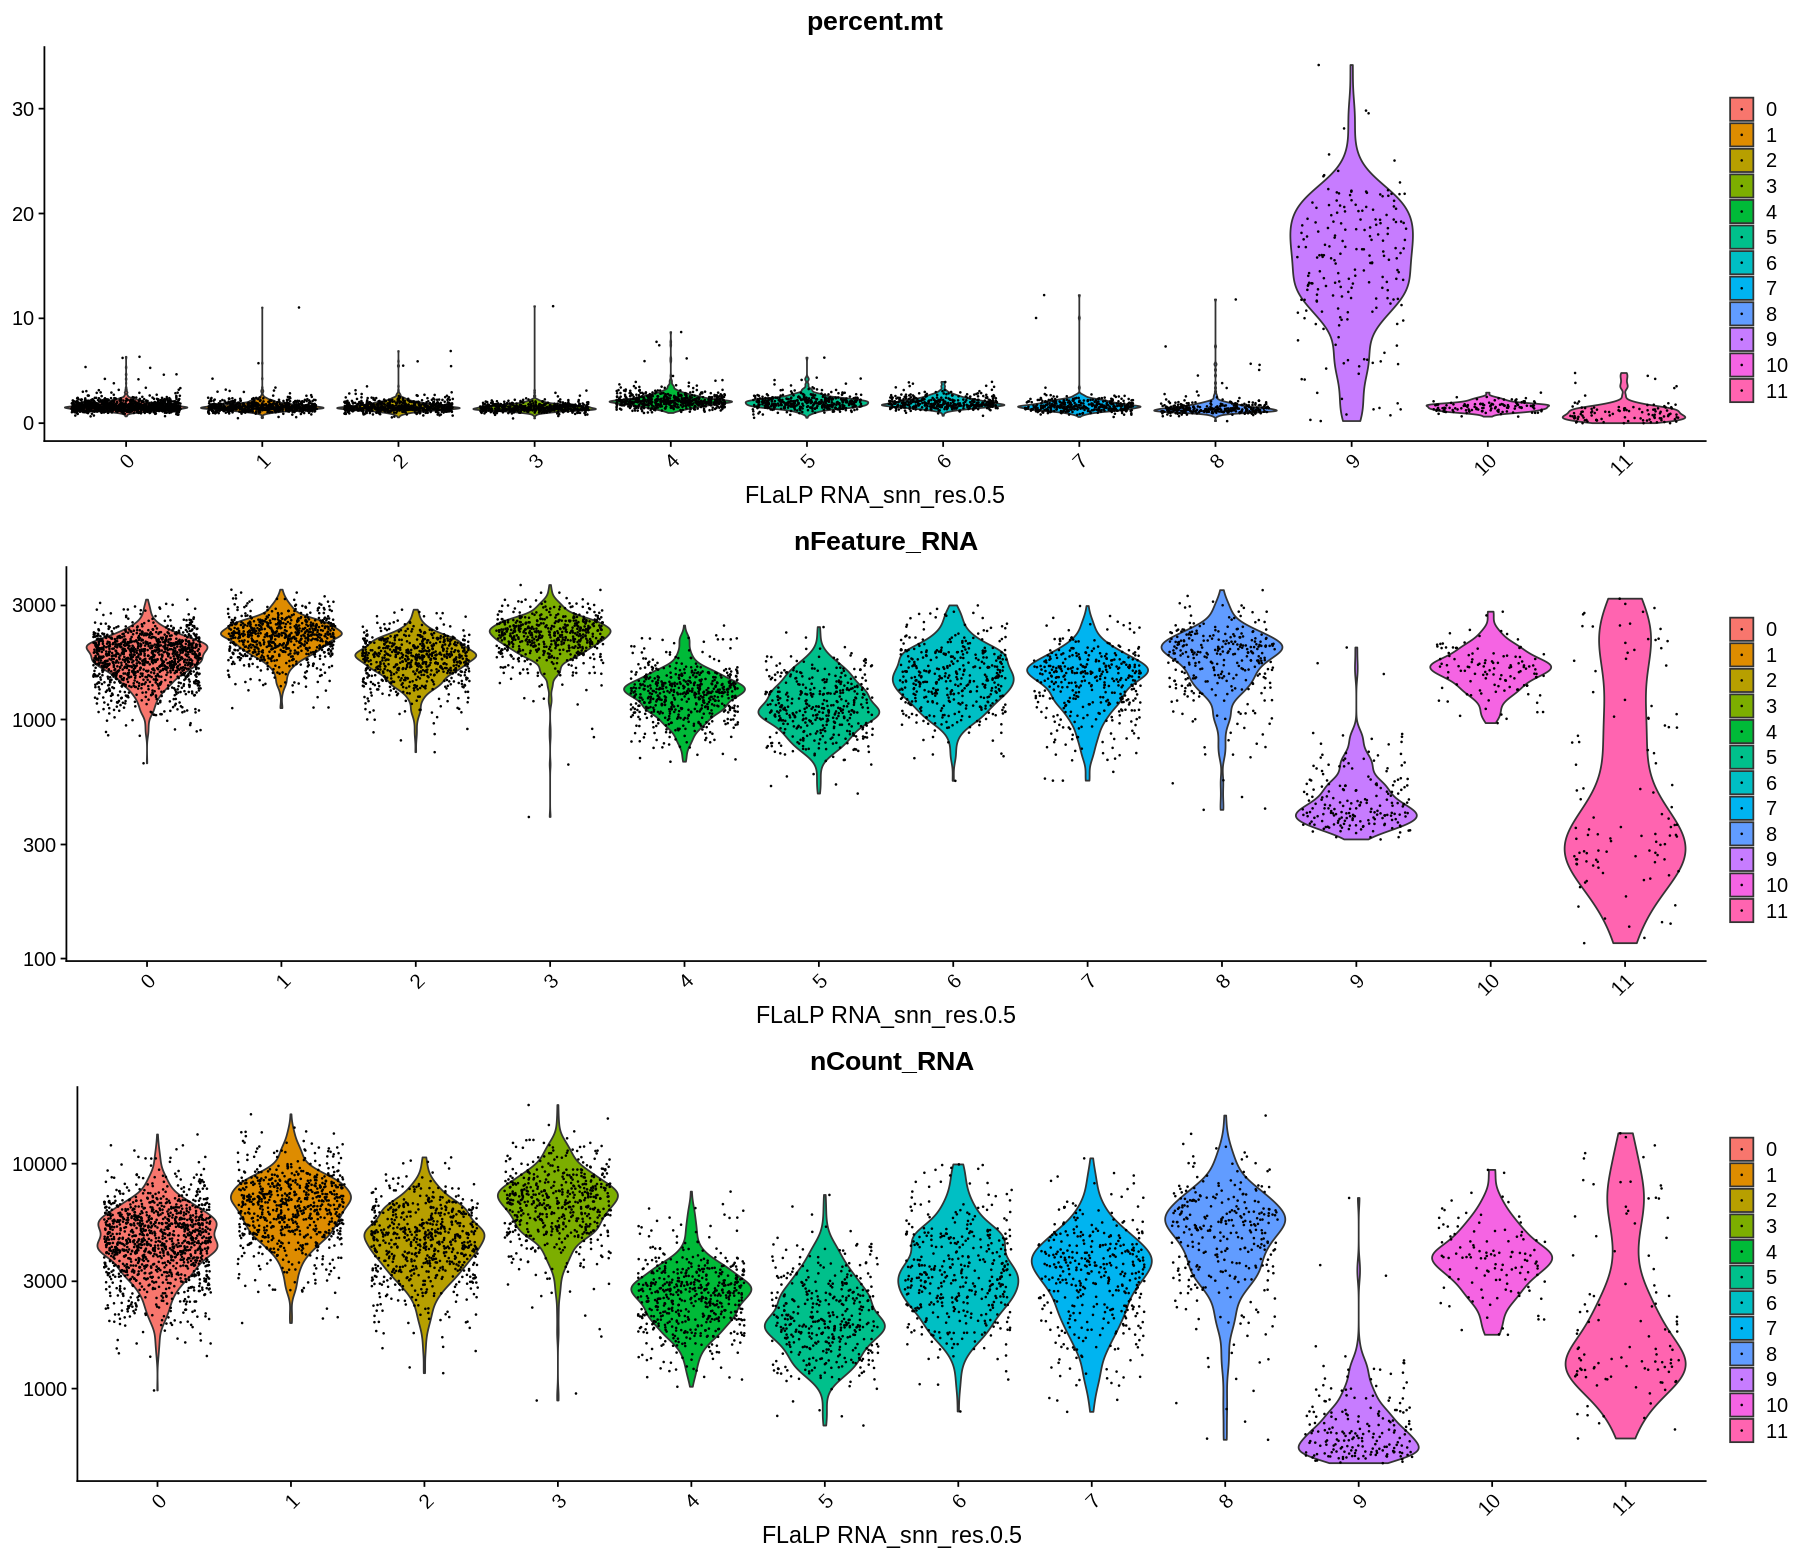

In [5]:
options(repr.plot.width=15, repr.plot.height=13)
Idents(seu)<-"RNA_snn_res.0.5"
group.by<-'RNA_snn_res.0.5'
ggarrange(ncol=1, nrow=3,
VlnPlot(seu, features = "percent.mt", pt.size=0.1, log=F, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nFeature_RNA", pt.size=0.1, log=T, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nCount_RNA", pt.size=0.1, y.max=10000,log=T, group.by=group.by)+xlab(paste(proj.name,group.by))
)

## Drop clusters with high mt-gene percentages

In [6]:
seu<-subset(seu, subset=RNA_snn_res.0.5!=9)

## Drop low-quality cells

In [7]:
seu<-subset(seu, subset=percent.mt<5 & nFeature_RNA>1000)

In [8]:
options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5),verbose=FALSE)
toc()

Centering and scaling data matrix



9.604 sec elapsed
17.683 sec elapsed
2.816 sec elapsed


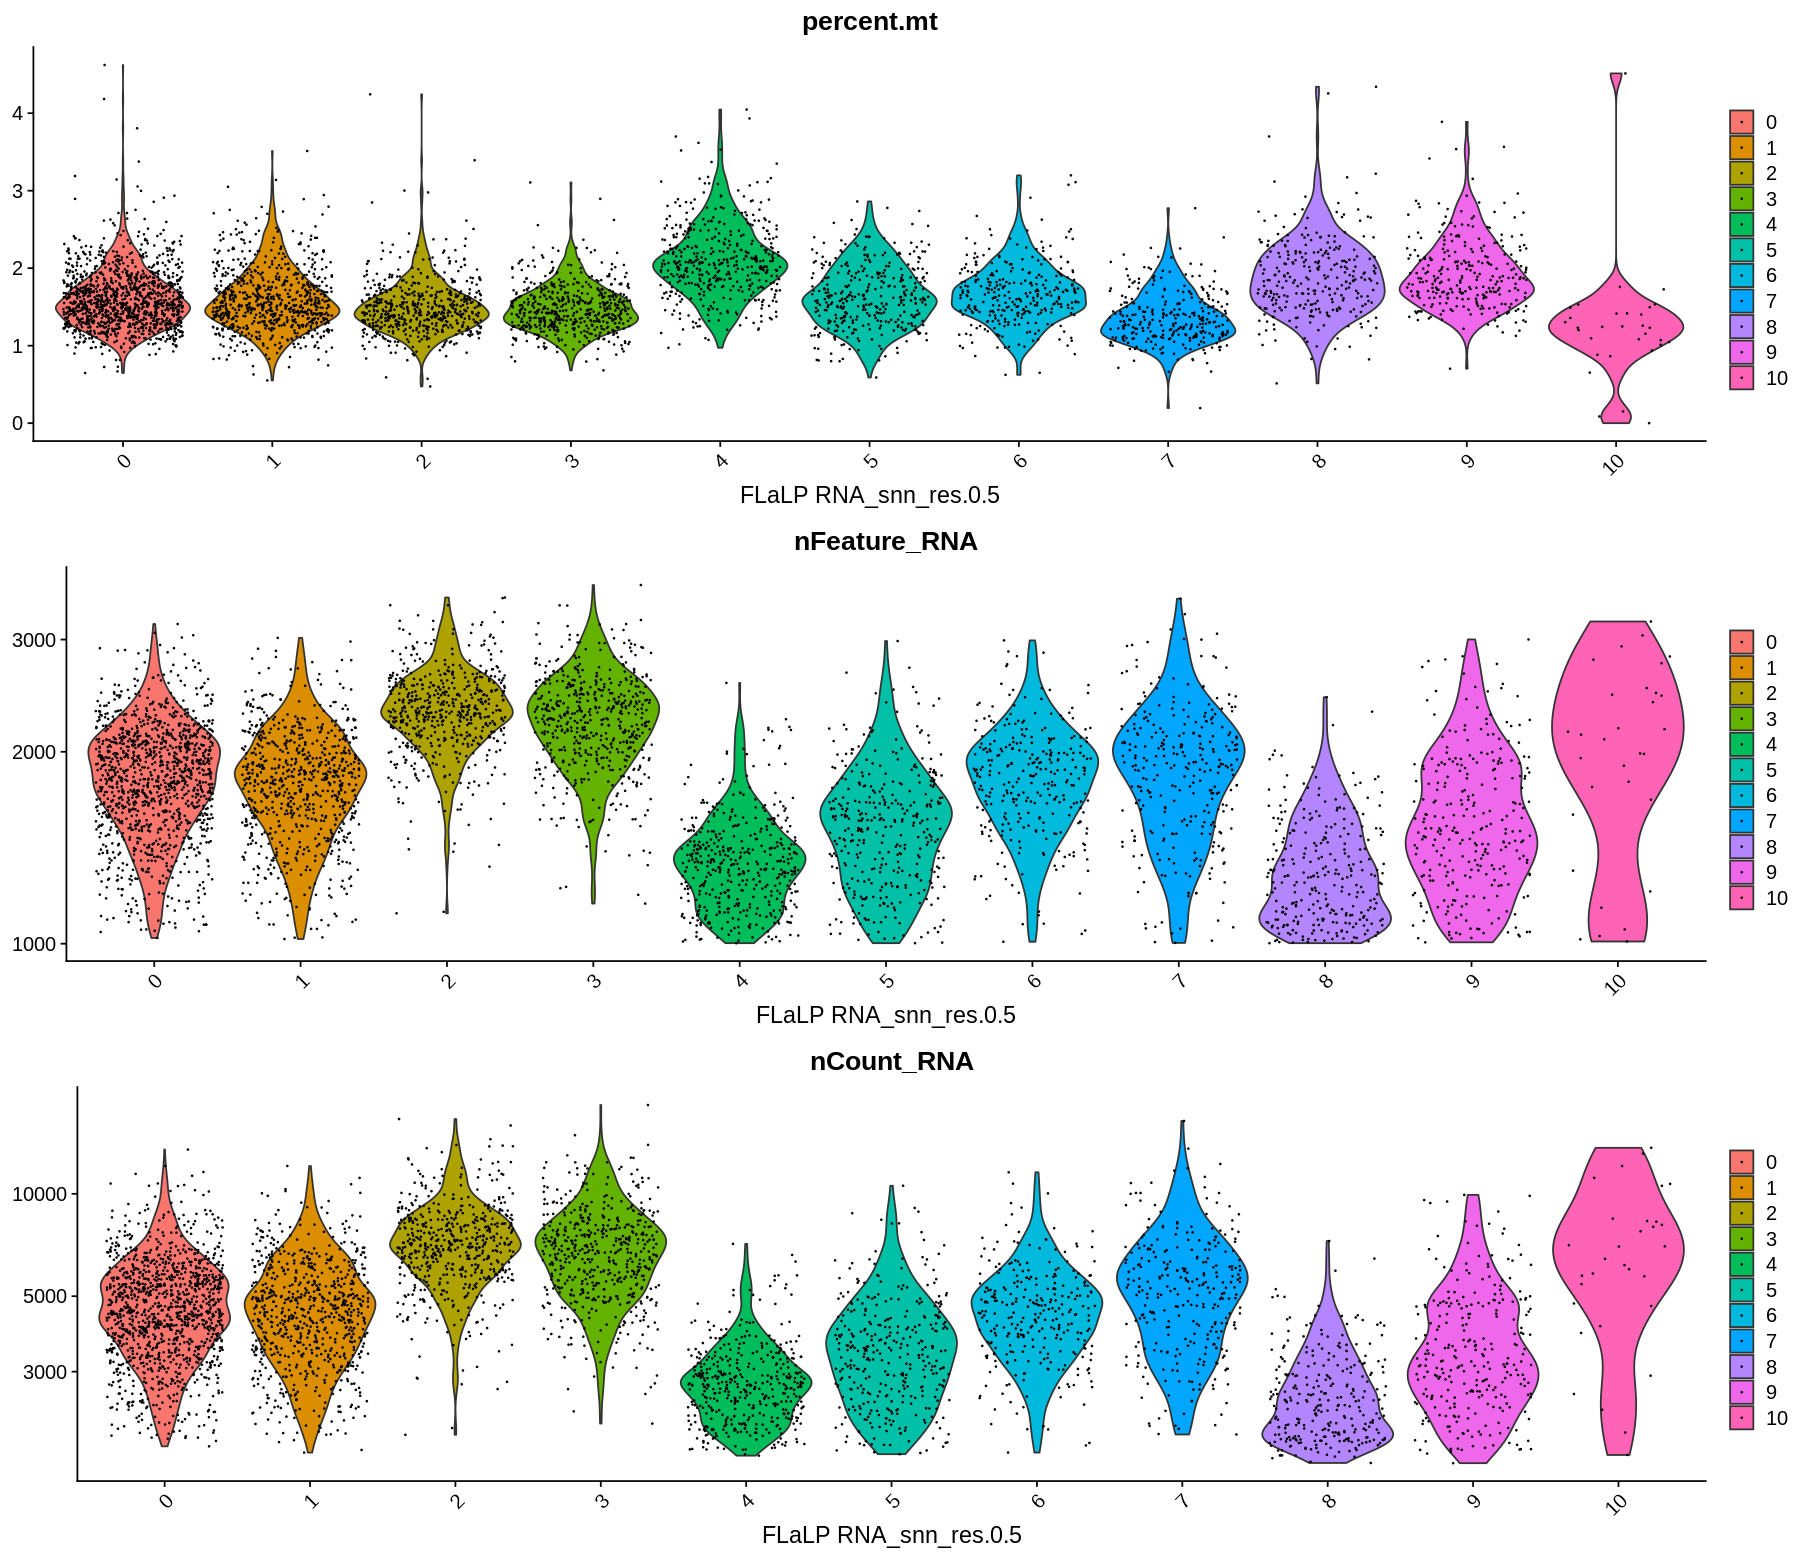

In [9]:
options(repr.plot.width=15, repr.plot.height=13)
Idents(seu)<-"RNA_snn_res.0.5"
group.by<-'RNA_snn_res.0.5'
ggarrange(ncol=1, nrow=3,
VlnPlot(seu, features = "percent.mt", pt.size=0.1, log=F, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nFeature_RNA", pt.size=0.1, log=T, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nCount_RNA", pt.size=0.1, y.max=10000,log=T, group.by=group.by)+xlab(paste(proj.name,group.by))
)

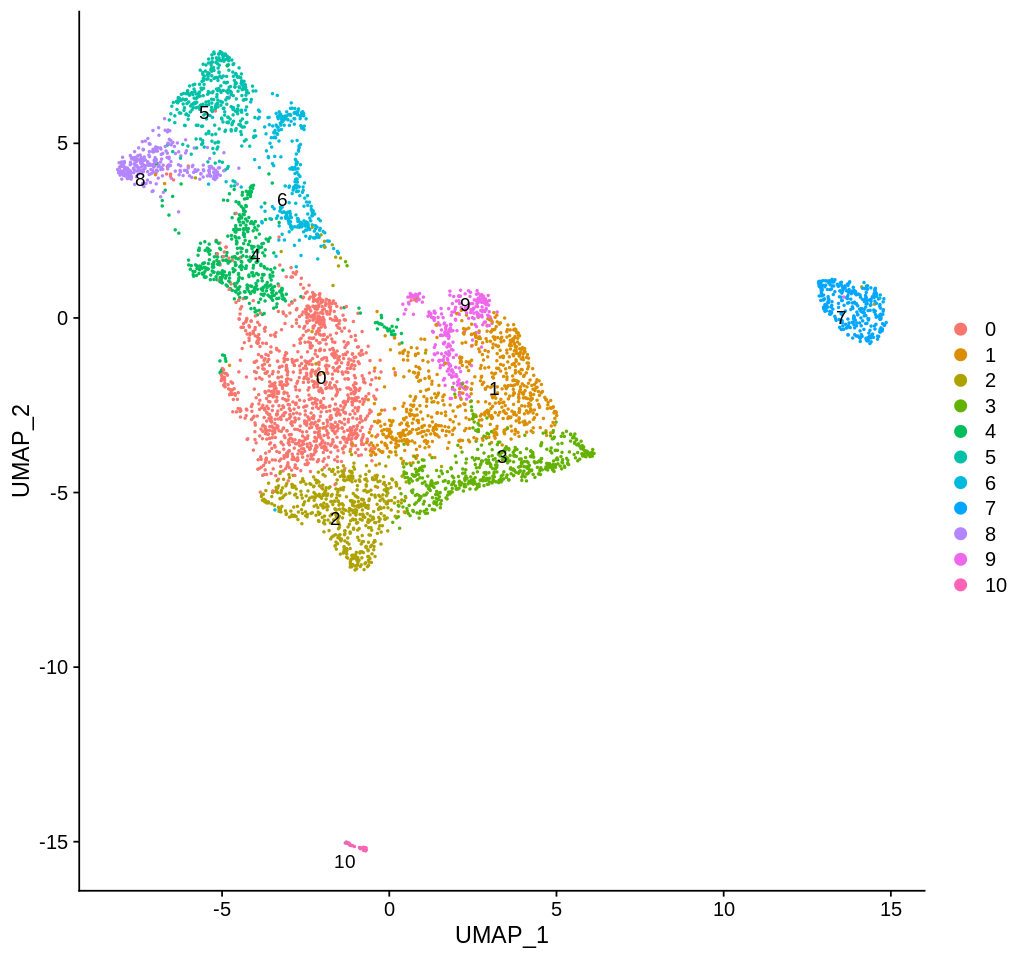

In [10]:
options(repr.plot.width=8.5, repr.plot.height=8)
UMAPPlot(seu, group.by="RNA_snn_res.0.5", label=T,repel=T)

## Doublet

In [11]:
options(warn =-1)
tic()
params<-DoubletRemovalParameters(seu, PCs=1:30)
toc()
options(warn =0)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997

sweep parameters: 249.587 sec elapsed
249.62 sec elapsed


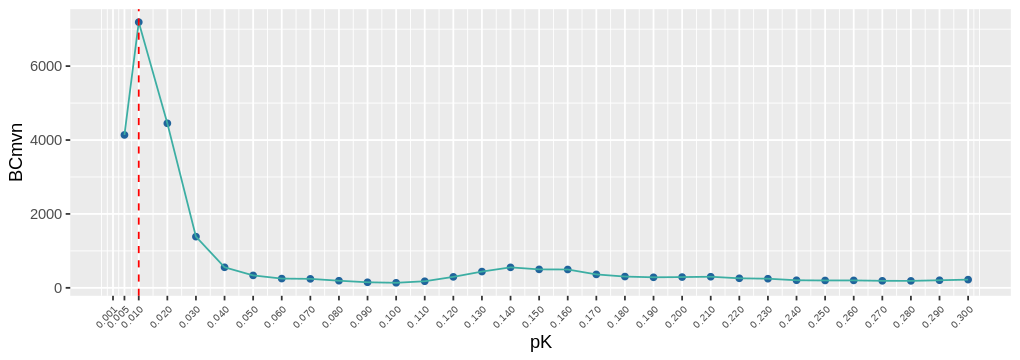

In [12]:
options(repr.plot.wdith=8, repr.plot.height=3)
bcmvnPlot(params$bcmvn, maxpos =0.01)

In [13]:
doublet.rate   <- 0.05
annotations    <- seu@meta.data$RNA_snn_res.0.5
homotypic.prop <- modelHomotypic(annotations) 
nExp_poi       <- round(doublet.rate*length(colnames(x = seu)))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
nExp_poi.adj   <- round(nExp_poi*(1-homotypic.prop))
nExp_poi.adj

[1] 222

In [14]:
pK <- 0.01

tic()
seu.scored     <- doubletFinder_v3(seu, PCs =1:30, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
toc()

# Run it only once!!! or may cause problem
cname     <- colnames(seu.scored[[]])
DF.name   <- cname[grep('^DF',cname)] 
pANN.name <- cname[grep('^pANN',cname)] 
seu.scored[["doublet"]]<-seu.scored[[DF.name]]
seu.scored[["pANN"]]   <-seu.scored[[pANN.name]]
seu.scored[[DF.name]]  <-NULL
seu.scored[[pANN.name]]<-NULL

[1] "Creating 1698 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
41.456 sec elapsed


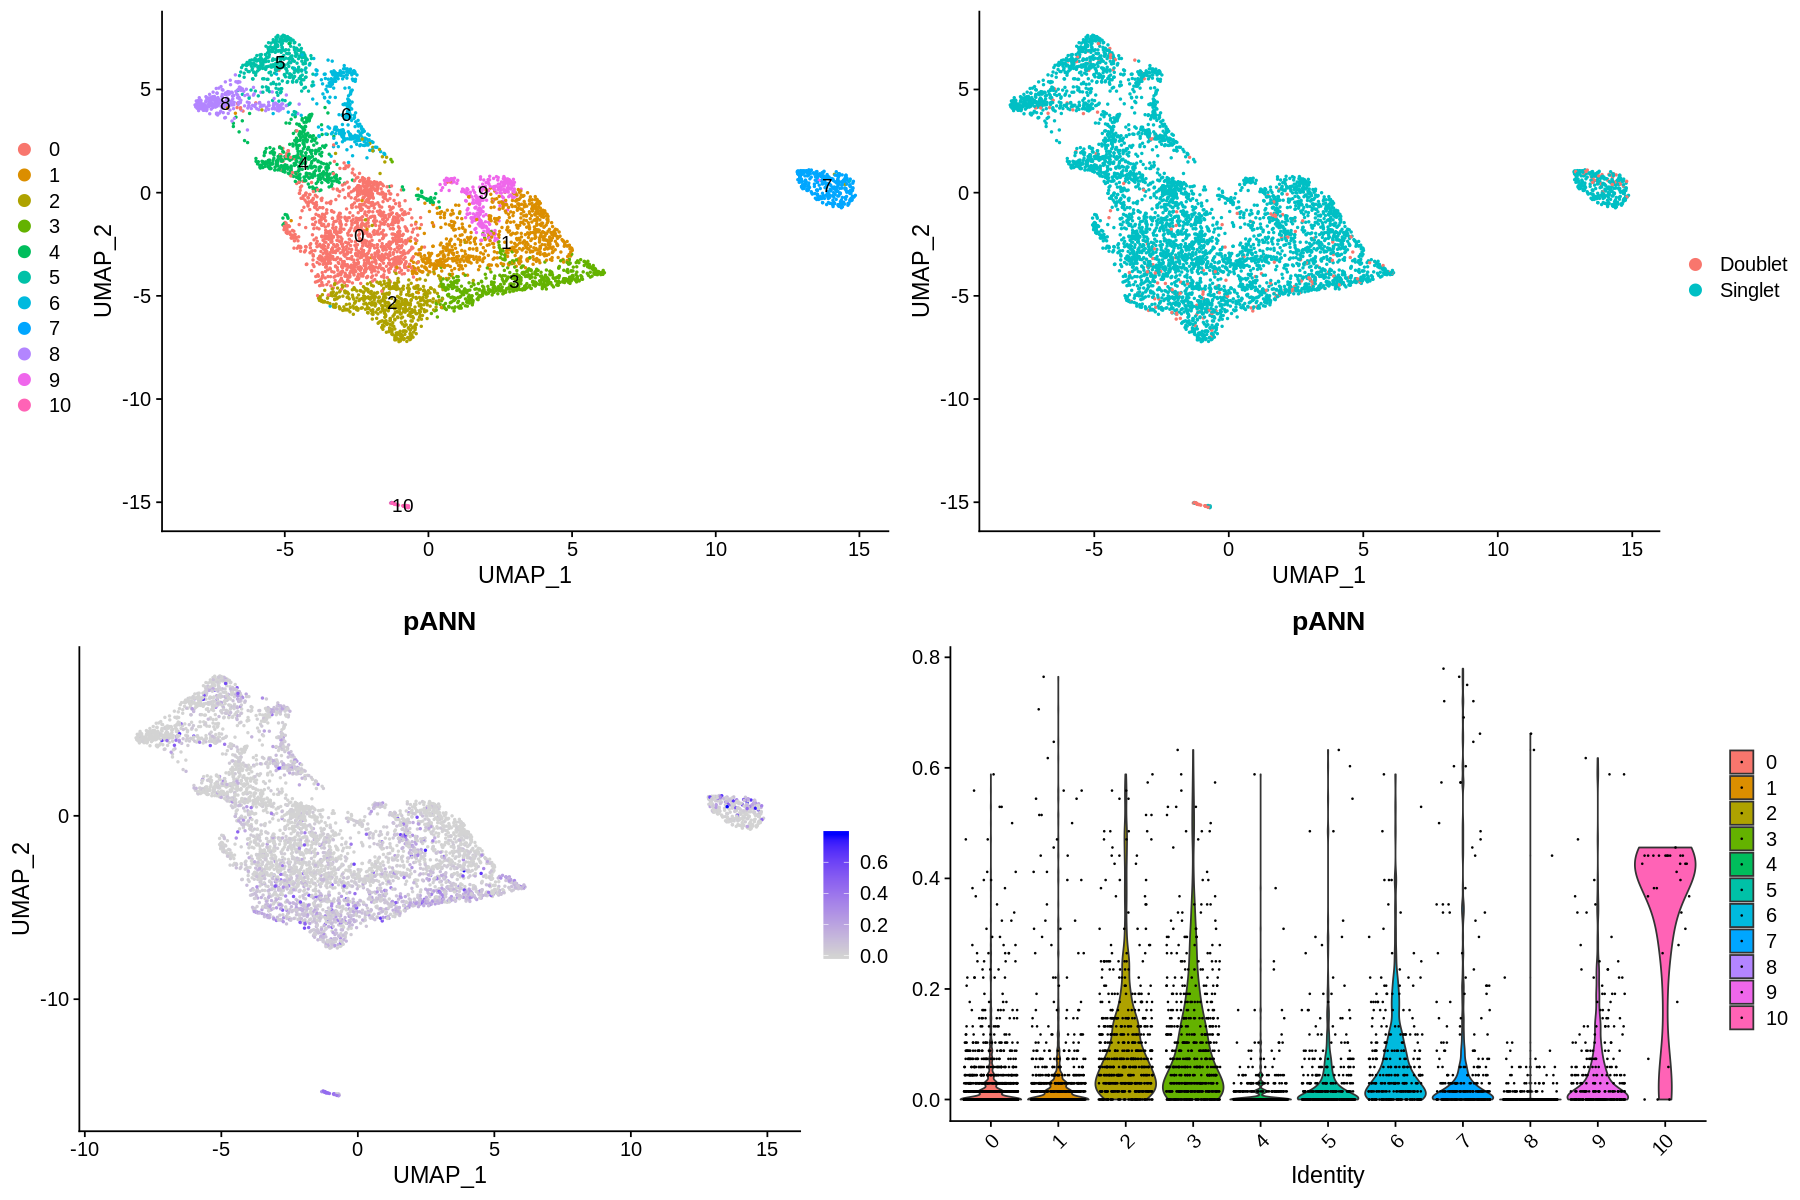

In [15]:
options(repr.plot.width=15,repr.plot.height=10)
p1<-DimPlot(seu.scored, reduction = "umap",label=T)+theme(legend.position="left")
p2<-DimPlot(seu.scored, reduction = "umap",group.by="doublet")+theme(legend.position="right")
p3<-FeaturePlot(seu.scored, features = "pANN")
p4<-VlnPlot(seu.scored, features = "pANN", group.by = "RNA_snn_res.0.5",pt.size=0.1)

library(ggpubr)
ggarrange(p1,p2,p3,p4,nrow=2,ncol=2)

In [19]:
seu.scored->seu

In [20]:
tic()
save(seu, file="./PP1_data/FLaLP_PP1.rda", compress=T)
toc()

53.638 sec elapsed
